Running Verification 4.1...


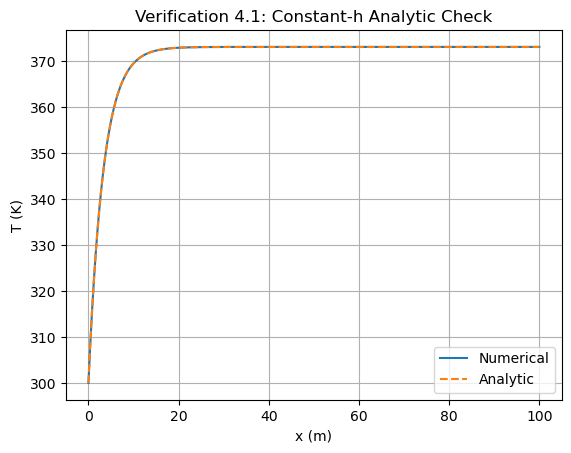

Running Verification 4.2...


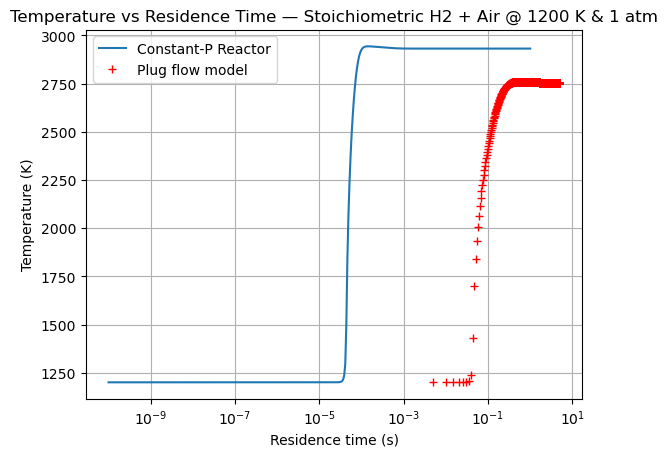

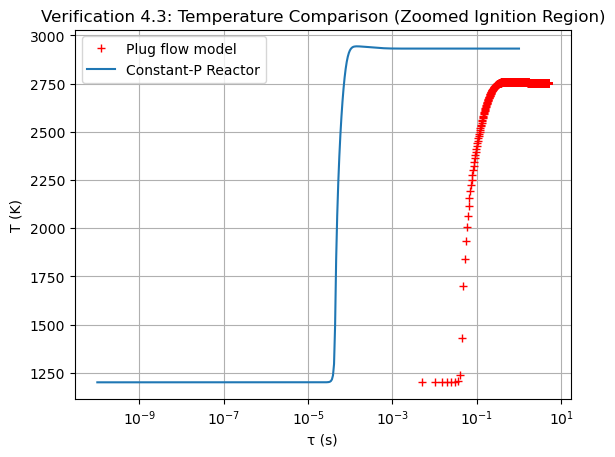

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
from Project_3_4 import solve_pfr_cantera  # Make sure it's in the same folder

# =============================================================================
# Shared Parameters
# =============================================================================
D = 0.05  # 5 cm
x_end = 100.0  # 100 meters
Npts = 2000
p0 = ct.one_atm

# =============================================================================
# Verification 4.1 — Constant h, inert gas (analytic check)
# =============================================================================
print("Running Verification 4.1...")

def h_const(T, Y, p, rho, u):
    return 100.0  # W/m^2-K

def Tw_const(x):
    return 373.15  # 100°C wall temp

gas = ct.Solution('gri30.yaml')
X0 = {'AR': 1.0}
T0 = 300.0
gas.TPX = T0, p0, X0
mdot = 0.1  # kg/s

sol = solve_pfr_cantera(
    'gri30.yaml', X0, T0, p0, mdot, D, Tw_const, x_end,
    Npts=Npts, h_override=h_const
)

# Analytic Solution
h = 100
cp = gas.cp_mass
rho = gas.density
Per = np.pi * D
A = np.pi * D**2 / 4.0
u = u0
mcp = mdot * cp
T_analytic = Tw_const(0) + (T0 - Tw_const(0)) * np.exp(-h * Per * sol['x'] / mcp)

plt.figure()
plt.plot(sol["x"], sol["T"], label="Numerical")
plt.plot(sol["x"], T_analytic, "--", label="Analytic")
plt.xlabel("x (m)")
plt.ylabel("T (K)")
plt.title("Verification 4.1: Constant-h Analytic Check")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# Verification 4.2 — Reacting gas, no heat transfer (compare to Cantera reactor)
# =============================================================================
print("Running Verification 4.2...")

X0 = {'H2': 2.0, 'O2': 1.0, 'N2': 3.76}
T0 = 1200.0
gas = ct.Solution('gri30.yaml')
gas.TPX = T0, p0, X0
rho = gas.density
A = np.pi * D**2 / 4.0
u0 = 10.0  # m/s
mdot = rho * A * u0

sol_pfr = solve_pfr_cantera(
    'gri30.yaml', X0, T0, p0, mdot, D, 0.0, x_end, Npts=Npts,
    h_override=lambda T, Y, p, rho, u: 0.0
)

# Compute residence time from local velocity
tau = np.zeros_like(sol_pfr["x"])
for i in range(1, len(tau)):
    dx = sol_pfr["x"][i] - sol_pfr["x"][i-1]
    T_local = sol_pfr["T"][i]
    Y_local = sol_pfr["Y"][:, i]
    gas.TPY = T_local, p0, Y_local
    rho_local = gas.density
    u_local = mdot / (rho_local * A)
    tau[i] = tau[i-1] + dx / u_local

# Cantera constant-pressure, fixed-mass reactor
gas.TPX = T0, p0, X0
r = ct.IdealGasReactor(gas, energy='on')
sim = ct.ReactorNet([r])
times = np.logspace(-10, 0, 400)
T_reactor = []
tau_reactor = []

for t in times:
    sim.advance(t)
    T_reactor.append(r.T)
    tau_reactor.append(t)

plt.figure()
plt.plot(tau_reactor, T_reactor, label="Constant-P Reactor")
plt.plot(tau, sol_pfr["T"], "r+", label="Plug flow model")
plt.xlabel("Residence time (s)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Residence Time — Stoichiometric H2 + Air @ 1200 K & 1 atm")
plt.xscale("log")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# Verification 4.3 — Zoomed in on ignition region (log x-scale)
# =============================================================================
plt.figure()
plt.plot(tau, sol_pfr["T"], "r+", label="Plug flow model")
plt.plot(tau_reactor, T_reactor, label="Constant-P Reactor")
plt.xscale("log")

plt.xlabel("τ (s)")
plt.ylabel("T (K)")
plt.title("Verification 4.3: Temperature Comparison (Zoomed Ignition Region)")
plt.legend()
plt.grid(True)
plt.show()